In [1]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print(torch.version.cuda)

Torch version: 2.5.1
Torchvision version: 0.20.1
12.1


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


## 获得模型和tokenizer

In [4]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
) # 4bit量化, block_size=5020
print(model)

==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.1.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.988 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaR

## 处理MMLU数据集，构造提示词

In [5]:
from datasets import load_dataset

mmlu = load_dataset("cais/mmlu", "all")
mmlu['auxiliary_train'][0]

README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

auxiliary_train-00000-of-00001.parquet:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

{'question': "Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were",
 'subject': '',
 'choices': ['Adams only.', 'Brooks only.', 'Case only.', 'Adams and Brooks'],
 'answer': 1}

在lm-evaluation-harness\tests\test_prompt.py可以找到MMLU的提示词模板  
在lm-evaluation-harness\lm_eval\__main__.py 可以找到lm_eval的所有参数（比如num_fewshot可以控制ICL examples的数量）

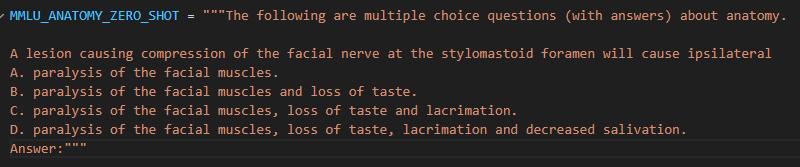

In [6]:
# 构建提示词模板

prompt_template="""The following are multiple choice questions (with answers) about {}.

{}
A. {}.
B. {}.
C. {}.
D. {}.
Answer:{}"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompt(examples):
    questions = examples['question']
    subjects = examples['subject']
    choices = examples['choices']
    answers = examples['answer']
    texts = []
    for question, subject, choice, answer in zip(questions, subjects, choices, answers):
        text = prompt_template.format(subject, question, choice[0], choice[1], choice[2], choice[3], answer) + EOS_TOKEN # 注意最后要加上EOS
        texts.append(text)
    return { "text" : texts, }

In [7]:
training_data=mmlu['auxiliary_train'].map(formatting_prompt, batched= True)

Map:   0%|          | 0/99842 [00:00<?, ? examples/s]

In [8]:
print(training_data['text'][0])

The following are multiple choice questions (with answers) about .

Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were
A. Adams only..
B. Brooks only..
C. Case only..
D. Adams and Brooks.
Answer:1<|end_of_text|>


In [9]:
# 计算所有text的长度
training_data = training_data.map(lambda x: {"text_len": len(x["text"])})
print(training_data[0]['text_len'])
print(len(training_data))

Map:   0%|          | 0/99842 [00:00<?, ? examples/s]

577
99842


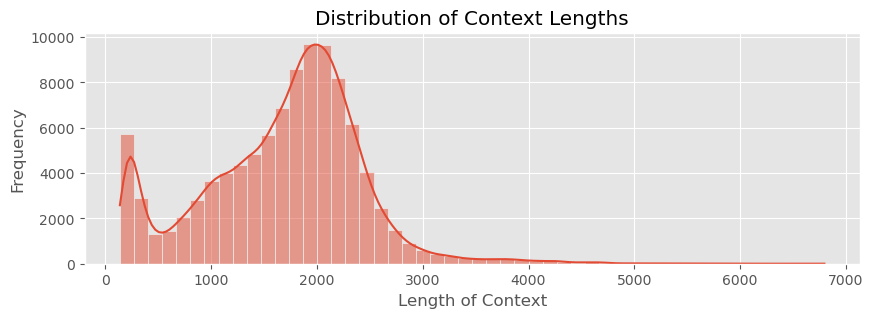

In [10]:
plt.figure(figsize=(10, 3))
sns.histplot(training_data['text_len'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

In [11]:
# 观察到绝大多数样本的长度<4000，这里我们直接删除掉长度>4000的样本即可
training_data = training_data.filter(lambda x: x["text_len"] <= 4000)
len(training_data)

Filter:   0%|          | 0/99842 [00:00<?, ? examples/s]

99264

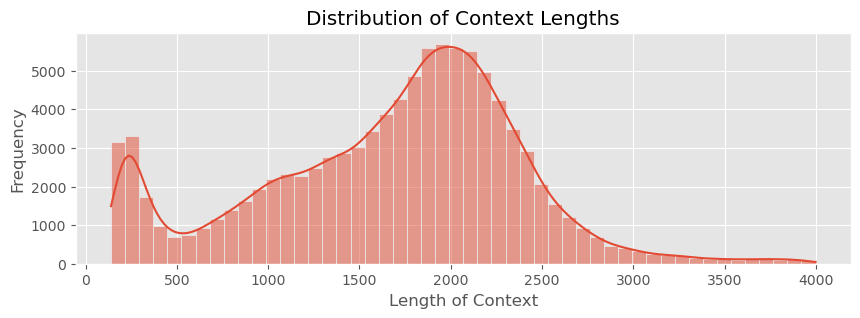

In [12]:
plt.figure(figsize=(10, 3))
sns.histplot(training_data['text_len'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

## LORA微调

In [13]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
) # 4bit量化, block_size=5020

==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.1.
   \\   /|    GPU: NVIDIA GeForce RTX 4090. Max memory: 23.988 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [14]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())

Unsloth 2024.11.7 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


In [15]:
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        per_device_train_batch_size=3,
        gradient_accumulation_steps=16,
        num_train_epochs=5,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
    ),
)

Generating train split: 0 examples [00:00, ? examples/s]

In [16]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 7,212 | Num Epochs = 5
O^O/ \_/ \    Batch size per device = 3 | Gradient Accumulation steps = 16
\        /    Total batch size = 48 | Total steps = 750
 "-____-"     Number of trainable parameters = 11,272,192


Step,Training Loss
1,2.615600
2,2.601100
3,2.601100
4,2.573500
5,2.529600
6,2.481600
7,2.468800
8,2.476800
9,2.430800
10,2.372300


TrainOutput(global_step=750, training_loss=1.9694689081509908, metrics={'train_runtime': 16006.8988, 'train_samples_per_second': 2.253, 'train_steps_per_second': 0.047, 'total_flos': 1.06742445539328e+18, 'train_loss': 1.9694689081509908, 'epoch': 4.9916805324459235})

In [17]:
model.save_pretrained("model/1B_finetuned_llama3.2_LoRA")
tokenizer.save_pretrained("model/1B_finetuned_llama3.2_LoRA")

('model/1B_finetuned_llama3.2_LoRA/tokenizer_config.json',
 'model/1B_finetuned_llama3.2_LoRA/special_tokens_map.json',
 'model/1B_finetuned_llama3.2_LoRA/tokenizer.json')